## попробуем то с чем стат модели не справились....
## Уровень 1: Классические ML Алгоритмы

### Цель :  
Освоить и сравнить основные алгоритмы детекции аномалий из `scikit-learn`. 
- 01. покрутим двукластерные данные из с 0-го уровня.

# Let's go ...

## 0. Подготовка

### Импорты

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from memory_profiler import memory_usage

from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    precision_recall_curve, auc, make_scorer
)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


import warnings
from IPython.display import display


warnings.filterwarnings('ignore')
# Этот стиль добавляет сетку на фон и делает график matplotlib более читаемыми
plt.style.use('seaborn-v0_8-whitegrid')

# инициализация генератора случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# названия генерируемых фичей
FEAT_1 = 'Feature_1'
FEAT_2 = 'Feature_2'

### Для кросс валидации

In [2]:
# Кросс-валидация с сохранением доли классов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# Кастомная метрика — F1-score по целевому (аномальному) классу
# ВАЖНО !!!!!!!!!!!!!!!!
#IsolationForest , LOF , OCSVM возвращает значения
# 1 для inliers (нормальные объекты)
# -1 для outliers (аномалии)
# реализуем функцию подсчёта f1
def anomaly_f1(model, X, y_true):
    #  1 → норм, -1 → аномалия
    y_pred = model.predict(X)
    # перекодируем: аном (-1) → 1, норм (1) → 0
    y_pred = np.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)

### Функции

In [3]:
# простенькая отрисовка
def scatterplot_X_and_y(x1, x2, y, title, xlabel, ylabel,
            fs=(6, 5), cmap='plasma', s=50, edg_c='k'):
    plt.figure(figsize=fs)
    plt.scatter(x1, x2, c=y, cmap=cmap, s=s, edgecolors=edg_c)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# генерация данных из ноутбука уровня 0 (0_01)
def generate_data_0 (n_samples=300, centers=1, cluster_std=1.0, random_state=42,
                  percentage_of_anomalies = 10, low=-10, high=10):
    
    np.random.seed(random_state)
    # генерация нормальных данных
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std,
                      random_state=random_state)
    # Добавление аномалий
    n_anomalies = n_samples * percentage_of_anomalies // 100
    anomalies = np.random.uniform(low=low, high=high, size=(n_anomalies, 2))
    X = np.vstack([X, anomalies])
    y = np.append(y, [-1]*n_anomalies)  # -1 = метка аномалии
    # меняем на метку 1
    # в ноутбуке уровня 0 такого не было
    y = np.where(y == -1, 1, 0)
    return X, y

# поиск лучших гиперпараметров по сетке
# с анализом времени и пиковой памяти
def timed_grid_search(model, params,  X, y,
                     cv = skf, scorer = anomaly_f1):
    grid = GridSearchCV(
        model, params, cv = cv, scoring=scorer, n_jobs=-1, verbose=1,
        return_train_score=True
    )
    
    start_time = time.time()
    
    # пиковое использования памяти 
    # Оборачиваем .fit() в функцию для memory_usage
    # для контролируемого запуска
    mem_usage = memory_usage((lambda: grid.fit(X, y)), max_iterations=1)
    
    fitting_time = time.time() - start_time
    #  вывод лучших параметров, времени обучения, макс памяти
    print("Лучшие параметры модели:", grid.best_params_)
    print(f"Время обучения: {fitting_time:.2f}s, максимальная память: {max(mem_usage):.1f} MiB")
    
    # Возвращаем обученный объект GridSearchCV
    return grid
    
###############################################################
# precision-recall кривая и confusion_matrix и метрики
# возвращаем предсказание аномалий 1, 0
def anomaly_predict(model, X):
    return np.where(model.predict(X) == -1, 1, 0)

# сырые оценки типа вероятностей
# инвертируем , чтобы аномалия - должно быть больше
def raw_scores(model, X):
    if hasattr(model, "decision_function"):
        raw_scores = model.decision_function(X)
    elif hasattr(model, "score_samples"):
        raw_scores = model.score_samples(X)    
    # else срабатывать не должно
    else:
        # fallback на бинарный predict
        raw_scores = anomaly_predict(model, X)
        print('raw_scores вернул predict, отрисовка PR curve и расчёт auc будeт неккоректны.')
    return -raw_scores

# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc

# precision-recall кривая и confusion_matrix
def plot_pr_curve_and_conf_matrix(model, X, y_true, main_label = ''):
    # 0) получаем предсказания и сырые и не очень)
    # получаем сырые оценки 
    y_scores = raw_scores(model, X)
    
    # и предсказания
    y_pred = anomaly_predict(model, X)

    # 1) оценка pr_curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_scores)
    # x  должен монотонно возрастать!!!!
    pr_auc = auc(x = recalls, y = precisions)

    # 2)отрисовка
    # # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')
    
    
    labels = ['Норм (0)', 'Аномалии (1)']
    
    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")
    
    # cm
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()
    
    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)
    
    pass


################################################################
    
# отрисовка результата работы модели
def plot_anomaly_field(
    X,
    model,
    y_true=None,                       # если передать истинные метки, то отрисуем их 
    offset = 0.2,                      # смещение для истинных меток
    model_name = 'model',
    resolution=100,                    # число точек по каждой оси для сетки
    cmap_bg="Greys", alpha_bg=0.3,     # для фонового поля
    show_scores=False,                 # если True то рисуем градиент предсказанной аномальности точек 
    figsize=(8,5),
    cmap="coolwarm", s=50, edge_c="k"  # для объектов
):
 
    # 0) получаем предсказания и сырые и не очень)
    # получаем сырые инвертированые оценки чем больше score тем аномальнее
    y_scores = raw_scores(model, X)
    
    # и предсказания аномалия = 1
    y_pred = anomaly_predict(model, X)
    
    # 1) Определяем границы
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min , y_max = X[:,1].min() - .5, X[:,1].max() + .5

    # 2) Строим сетку
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 3) Получаем «сырые» оценки для сетки
    grid_scores = raw_scores(model, grid)

    # 4) Нормируем к диапазону [0,1]
    s_min, s_max = grid_scores.min(), grid_scores.max()
    if s_max > s_min:
        norm_scores = (grid_scores - s_min) / (s_max - s_min)
    else:
        norm_scores = np.zeros_like(grid_scores)

    zz = norm_scores.reshape(xx.shape)

    # 5) Рисуем фон
    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, zz, 15, cmap=cmap_bg, alpha=alpha_bg)
    cb = plt.colorbar()
    cb.set_label("Нормализованная оценка аномалии пространства", rotation=270, labelpad=15)

    # 6) Наносим точки
    # Если показвать предсказанные аномалии в градиенте 
    if show_scores:
        labelbar = "Оценка аномалии"
    # если показ оценки не нужен то и не фик...
    else:
        y_scores = y_pred 
        labelbar = "Предсказанный класс"


    # 7)Рисуем
    sc = plt.scatter(X[:, 0], X[:, 1],
                     c=y_scores, cmap=cmap,
                     s=s, edgecolors=edge_c,
                      label='Объекты',
                     )
    plt.title(f"Аномалии от {model_name}")
    plt.xlabel("x 1")
    plt.ylabel("x 2")
    plt.grid(True)
    cb = plt.colorbar()
    cb.set_label(labelbar, rotation=270, labelpad=15)

    # 8)Если есть истинные метки, можно их нарисовать крестикаме
    if y_true is not None:
        anom = np.where(y_true == 1)[0]
        plt.scatter(X[anom, 0] + offset, X[anom, 1]+ offset,
                    marker='X', s=s, label='Истинные', linewidths=2, c='yellow',
                    edgecolors="black", alpha=0.5)
        plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

## 1. Посмотрим на данные из 0-го уровня с двумя кластерами

### 1.1. Генерация тестовых данных 

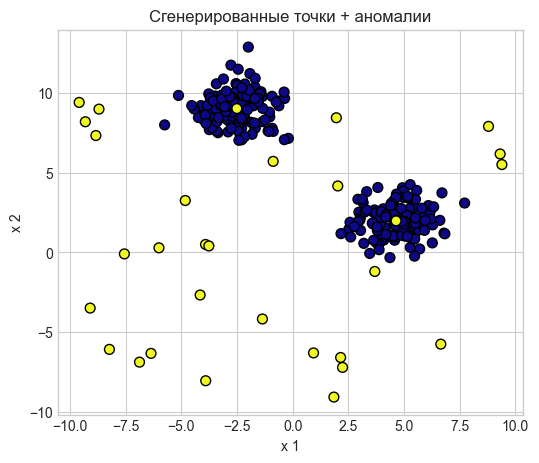

In [4]:
# Генерация данных
X, y = generate_data_0(n_samples=300, centers=2)

# Визуализация
scatterplot_X_and_y(X[:, 0], X[:, 1], y, "Сгенерированные точки + аномалии", "x 1", "x 2", )

### 1.2 Isolation Forest

In [5]:
# Поиск гиперпараметров
iso = IsolationForest(random_state=RANDOM_STATE)

param_iso = {
    'n_estimators': [5, 10, 20, 100],
    'contamination': [ 0.01, 0.07, 0.1, 0.13, 0.18 ]
}


grid_iso = timed_grid_search(iso, param_iso, X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры модели: {'contamination': 0.07, 'n_estimators': 10}
Время обучения: 4.88s, максимальная память: 189.9 MiB


In [6]:
# Получение результатов
results = grid_iso.cv_results_

# Вывод оценок по каждой итерации
for mean_test_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Test Score: {mean_test_score:.4f} | Parameters: {params}")

Test Score: 0.1143 | Parameters: {'contamination': 0.01, 'n_estimators': 5}
Test Score: 0.2476 | Parameters: {'contamination': 0.01, 'n_estimators': 10}
Test Score: 0.1905 | Parameters: {'contamination': 0.01, 'n_estimators': 20}
Test Score: 0.2333 | Parameters: {'contamination': 0.01, 'n_estimators': 100}
Test Score: 0.7646 | Parameters: {'contamination': 0.07, 'n_estimators': 5}
Test Score: 0.8570 | Parameters: {'contamination': 0.07, 'n_estimators': 10}
Test Score: 0.8152 | Parameters: {'contamination': 0.07, 'n_estimators': 20}
Test Score: 0.8303 | Parameters: {'contamination': 0.07, 'n_estimators': 100}
Test Score: 0.7779 | Parameters: {'contamination': 0.1, 'n_estimators': 5}
Test Score: 0.8090 | Parameters: {'contamination': 0.1, 'n_estimators': 10}
Test Score: 0.8089 | Parameters: {'contamination': 0.1, 'n_estimators': 20}
Test Score: 0.7884 | Parameters: {'contamination': 0.1, 'n_estimators': 100}
Test Score: 0.7245 | Parameters: {'contamination': 0.13, 'n_estimators': 5}
Test

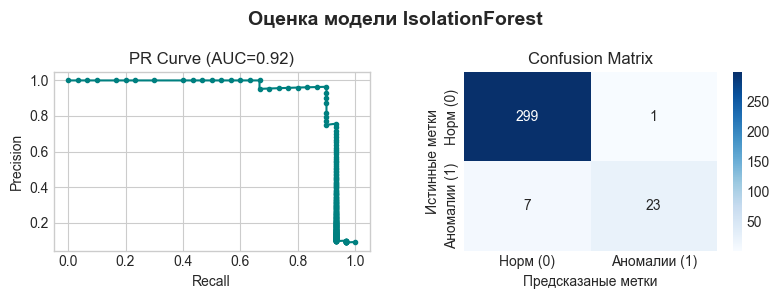


Precision=0.96,   Recall=0.77,   F1=0.85,   PR_AUC=0.92



In [7]:
# Оценка 
plot_pr_curve_and_conf_matrix(grid_iso, X, y,'IsolationForest' )

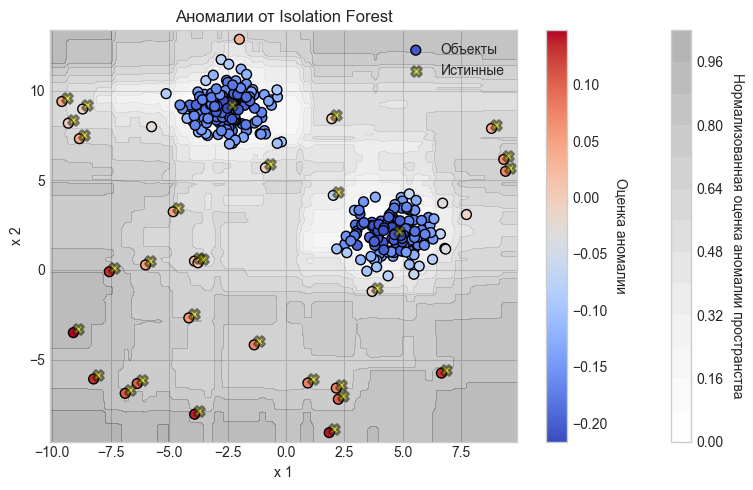

In [8]:
# отрисовка 
# чем краснее точка - тем больше модель уверена в её аномальности
# чем темнее фон тем сильее уверена модель в аномальности точек пространства
plot_anomaly_field(X, grid_iso, y_true=y, model_name = 'Isolation Forest', show_scores=True )

### 1.3 LocalOutlierFactor

In [9]:
# Поиск гиперпараметров
lof = LocalOutlierFactor(novelty=True)

param_lof = {
    'n_neighbors': [10, 50, 80, 100, 120],
    'contamination': [0.01, 0.05, 0.1, 0.15]
}

grid_lof = timed_grid_search(lof, param_lof, X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры модели: {'contamination': 0.1, 'n_neighbors': 100}
Время обучения: 0.77s, максимальная память: 200.4 MiB


In [10]:
# # Получение результатов
# results = grid_lof.cv_results_

# # Вывод оценок по каждой итерации
# for mean_test_score, params in zip(results['mean_test_score'], results['params']):
#     print(f"Test Score: {mean_test_score:.4f} | Parameters: {params}")

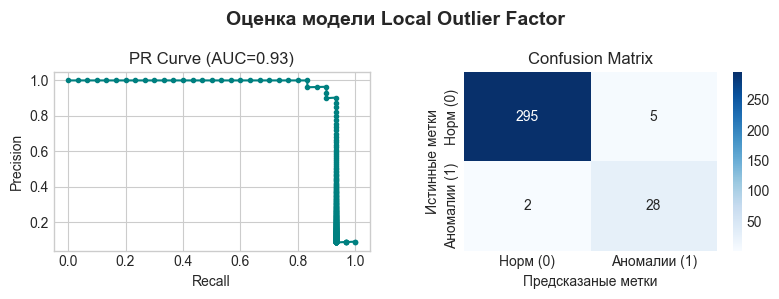


Precision=0.85,   Recall=0.93,   F1=0.89,   PR_AUC=0.93



In [11]:
# Оценка
plot_pr_curve_and_conf_matrix(grid_lof, X, y, 'Local Outlier Factor' )

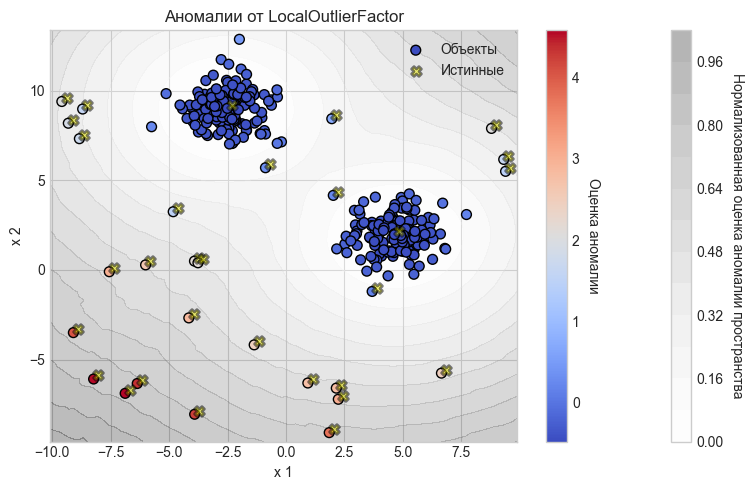

In [12]:
# отрисовка 
# чем краснее точка - тем больше модель уверена в её аномальности
# чем темнее фон тем сильее уверена модель в аномальности точек пространства
plot_anomaly_field(X, grid_lof, y_true=y, model_name = 'LocalOutlierFactor', show_scores=True )

### 1.4 OneClassSVM

In [13]:
# Поиск гиперпараметров
ocsvm = OneClassSVM(kernel='rbf')

param_ocsvm = {
    'nu': [0.003, 0.007, 0.01, 0.02, 0.05],
    'gamma': ['scale',  0.1, 0.5, 1]
}

grid_ocsvm = timed_grid_search(ocsvm, param_ocsvm, X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры модели: {'gamma': 0.1, 'nu': 0.007}
Время обучения: 0.73s, максимальная память: 199.7 MiB


In [14]:
# Получение результатов
results = grid_ocsvm.cv_results_

# Вывод оценок по каждой итерации
for mean_test_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Test Score: {mean_test_score:.4f} | Parameters: {params}")

Test Score: 0.5217 | Parameters: {'gamma': 'scale', 'nu': 0.003}
Test Score: 0.5217 | Parameters: {'gamma': 'scale', 'nu': 0.007}
Test Score: 0.5217 | Parameters: {'gamma': 'scale', 'nu': 0.01}
Test Score: 0.5217 | Parameters: {'gamma': 'scale', 'nu': 0.02}
Test Score: 0.6117 | Parameters: {'gamma': 'scale', 'nu': 0.05}
Test Score: 0.6379 | Parameters: {'gamma': 0.1, 'nu': 0.003}
Test Score: 0.6596 | Parameters: {'gamma': 0.1, 'nu': 0.007}
Test Score: 0.6552 | Parameters: {'gamma': 0.1, 'nu': 0.01}
Test Score: 0.6514 | Parameters: {'gamma': 0.1, 'nu': 0.02}
Test Score: 0.6514 | Parameters: {'gamma': 0.1, 'nu': 0.05}
Test Score: 0.4246 | Parameters: {'gamma': 0.5, 'nu': 0.003}
Test Score: 0.5011 | Parameters: {'gamma': 0.5, 'nu': 0.007}
Test Score: 0.5280 | Parameters: {'gamma': 0.5, 'nu': 0.01}
Test Score: 0.5412 | Parameters: {'gamma': 0.5, 'nu': 0.02}
Test Score: 0.5493 | Parameters: {'gamma': 0.5, 'nu': 0.05}
Test Score: 0.3122 | Parameters: {'gamma': 1, 'nu': 0.003}
Test Score: 0.3

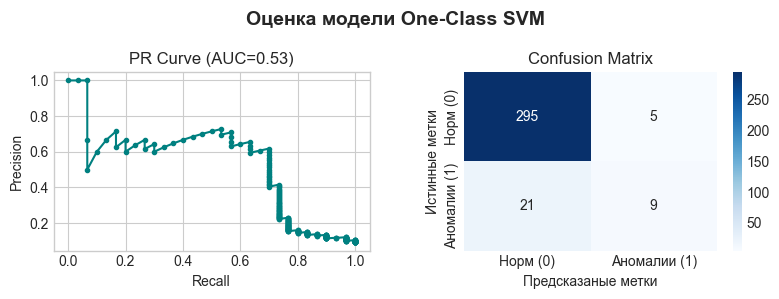


Precision=0.64,   Recall=0.30,   F1=0.41,   PR_AUC=0.53



In [15]:
# оценка
plot_pr_curve_and_conf_matrix(grid_ocsvm, X, y, 'One-Class SVM' )

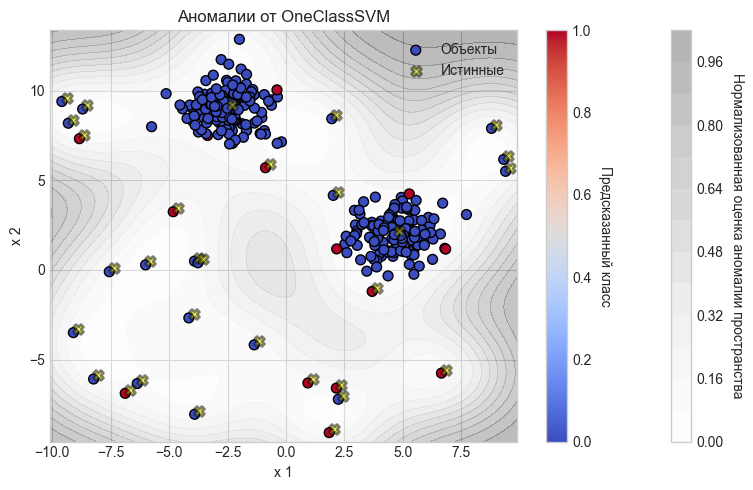

In [16]:
plot_anomaly_field(X, grid_ocsvm, y_true=y, model_name = 'OneClassSVM') #,show_scores=True )

## 2. Итог

### 2.1 Сравнение со стат методами
В сравнении со статистическими методами  rлассические ML алгоритмы дают лучшие результаты на более сложных (многокластерных ) данных.


### 2.2 Анализ результатов:
**IsolationForest**
- Очень высокая точность 0.96- ложных срабатываний мало.
- Recall = 0.77 - пропускает около четверти аномалий.
- F1 = 0.85 - хорошая сбалансированность точность-полнота.
- PR_AUC = 0.92 хорош, особенно для несбалансированных данных.
- **минимум ложных срабатываний (только 1) **

**LocalOutlierFactor**
- Precision = 0.85 хуже, чем у Isolation Forest больше ложных тревог, но приемлемо
- Recall = 0.93 — почти все аномалии обнаружены.
- F1 = 0.89  PR AUC= 0.93 лучшие, LOF - молодец
- **обнаружил почти все аномалии !!! (две спрятаные в нормальных объектах как найти ?)**

**OneClassSVM**
- Низкий Recall 0.30, прошляпил 21 аномалию из 30...
- Precision = 0.64 и F1 = 0.41 тоже очень не очень....
-  PR AUC = 0.53 слабая способность ранжирования....
-  Высокий уровень ложных срабатываний, низкое обнаружение реальных аномалий.

### 2.3 P.S.

**IsolationForest** 
- Чётко разбивает пространство на зоны с разным уровнем аномалий границы которых параллельны осям

**LocalOutlierFactor**
- Плавный градиент оценок пространства без резких перепадов

**OneClassSVM**
- Нет четкой кластеризации нормальных объектов...  
отсутствие устойчивой решающей границы ...  
всё как бы плохо ...  
но необходимо помнить, что OCSVM видит данные в пространстве более высокой размерности (с RBF - в бесконечномерном), анализирует то, что недоступно другим алгоритмам и ищет аномалии основанные на комбинации признаков, неочевидной в исходном пространстве. Клёво!!!

# Happy end.....